In [1]:
#!/usr/bin/env python3 

In [1]:
# Importing the necessary modules 
import os 
import cv2 
import random 
import joblib as jb 
import numpy as np 
import keras
import joblib 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from imutils import paths 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.layers import Flatten, MaxPool2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, Dense, Activation, Dropout 

In [2]:
# Setting the path to the gesture control data 
imgDir = "dataset/"

# Getting the image path 
imagePaths = sorted(list(paths.list_images(imgDir)))
random.seed(55) 
random.shuffle(imagePaths) 

# Initialize the data and labels 
data = []
labels = []

# loop over the input images 
for imagePath in imagePaths: 
    # load the image, pre-process it, and store it in the data list 
    image = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE)
    # Resizing the image 
    image = cv2.resize(image, (96, 96))
    
    # Converting the image into an array 
    image = img_to_array(image) 
    data.append(image) 
    
    # Extract a set of class labels from the image path and append the 
    # Values to the label list 
    outputValue = imagePath.split("/")[-2]
    labels.append(outputValue) 
    


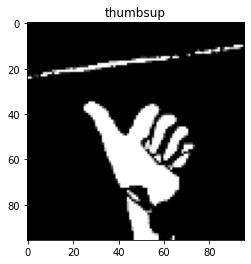

In [3]:
# Displaying some random plots 
plt.imshow(data[0], cmap="gray")
plt.title(labels[0])
plt.show() 

In [4]:
# Getting the length of the data 
print("Total input data: ", len(data))
print("Total output data: ", len(labels))

# Spacing in display 
!echo " "

# Displaying the unique output/labels features 
print("Unique labels: ", np.unique(labels))
print("\n")

# Displaying the shape of the data 
print("Data Shape: ", data[0].shape)

Total input data:  6300
Total output data:  6300
 
Unique labels:  ['fist' 'five' 'four' 'peace' 'three' 'thumbsup' 'unknown']


Data Shape:  (96, 96, 1)


In [5]:
# Scaling the data for both input and output features 
data = np.array(data, dtype="float32") / 255.0 
labels = np.array(labels) 

# Binarize the label and scale down the class 
lb = LabelEncoder() 
encoded_labels = lb.fit_transform(labels)

# Converting the encoded labels features into categorical data for easy modelling 
encoded_labels = to_categorical(encoded_labels, num_classes=len(lb.classes_))

In [6]:
# Getting the number of label classes (Output features)
numclasses = len(lb.classes_) 
print("Number of Classes: ", numclasses)

Number of Classes:  7


In [7]:
# Saving both the input and output features raw 
np.save("dataset/data", data)
np.save("dataset/labels", labels) 

In [8]:
# Saving the encoded labels and the encoder-model 
jb.dump(lb, "encoder/lb_encoder")
jb.dump(encoded_labels, "encoder/encoded_labels")

['encoder/encoded_labels']

<b> <h2> Loading The Serilized Model And Datasets </h2> </b> 

In [18]:
# loading the input and output features rawww 
data = np.load("dataset/data.npy")
labels = np.load("dataset/labels.npy")

# loading the saved encoded labels and the encoder-model 
lb = jb.load("encoder/lb_encoder")

In [9]:
# Getting the label names and the number of classes  
print("Label Classes Number: {} \nLabel Names: {}".format(numclasses, lb.classes_))
print("---------------------------------------------------------------- \n")

# Displaying the values for the input and output features 
print("Input Features: ", len(data))
print("Output Features: ", len(labels))
print("---------------------------------------------------------------- \n")

Label Classes Number: 7 
Label Names: ['fist' 'five' 'four' 'peace' 'three' 'thumbsup' 'unknown']
---------------------------------------------------------------- 

Input Features:  6300
Output Features:  6300
---------------------------------------------------------------- 



In [10]:
# Splitting the features into training and testing splits using 80% of 
# the data for training and the remaining 20% for testing 
(X_train, X_test, y_train, y_test) = train_test_split(data, encoded_labels, 
                                                     test_size=0.33, random_state=42)

# Displaying the shape of both the input and output features 
print("Input Shape: {}, {}".format(X_train.shape, X_test.shape)) 
print("Output Shape: {}, {}".format(y_train.shape, y_test.shape))

Input Shape: (4221, 96, 96, 1), (2079, 96, 96, 1)
Output Shape: (4221, 7), (2079, 7)


In [11]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

# Creating a class for constructing the VGGNet model 
class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes, finalAct="softmax"):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation(finalAct))

        # return the constructed network architecture
        return model
    
# Creating an instance of the SmallerVGGNet model   
model = SmallerVGGNet().build(96, 96, 1, numclasses)


# Compiling the model 
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Model summary 
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0

In [12]:
# Building the model 
# model = Sequential() 
# model.add(Conv2D(filters = 32, kernel_size=(3, 3), input_shape = (96, 96, 1)))
# model.add(Activation("relu"))

# # Adding another layer 
# model.add(Conv2D(filters = 32, kernel_size=(3, 3)))
# model.add(Activation("relu"))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.3))

# # Adding another layer 
# model.add(Conv2D(filters = 64, kernel_size = (3, 3)))
# model.add(Activation("relu"))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.3))

# # Adding the last layer 
# model.add(Flatten()) 
# model.add(Dense(256, activation="relu"))
# model.add(Dense(numclasses, activation="softmax"))

# # Compiling the model 
# model.compile(loss="categorical_crossentropy", optimizer= "adam", 
#              metrics = ["accuracy"])

# Building the model 
# def DefineModel(): 
#     model = Sequential([
#         Conv2D(32, 3, padding='same', activation='relu', input_shape=(96, 96, 1)), 
#         MaxPooling2D(), 
#         Conv2D(32, 3, padding='same', activation='relu'), 
#         MaxPooling2D(), 
#         Conv2D(64, 3, padding='same', activation='relu'), 
#         MaxPooling2D(), 
#         Flatten(), 
#         Dense(512, activation='softmax'), 
#         Dense(numclasses)
#     ])
    
#     # Compiling the model 
#     model.compile(optimizer='adam',
#                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#                   metrics=['accuracy'])
    
#     # Returning the model 
#     return model 

# # Creating the model 
# model = DefineModel() 

# # Displaying the summary of the model 
# model.summary() 

In [36]:
# Training the model 
H = model.fit(X_train, y_train, epochs = 20, batch_size=5, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20
845/845 [==============================] - 156s 185ms/step - loss: 0.6461 - accuracy: 0.9500 - val_loss: 0.6416 - val_accuracy: 0.9808
Epoch 2/20
845/845 [==============================] - 162s 191ms/step - loss: 0.6463 - accuracy: 0.9476 - val_loss: 0.6403 - val_accuracy: 0.9904
Epoch 3/20
845/845 [==============================] - 154s 182ms/step - loss: 0.6451 - accuracy: 0.9566 - val_loss: 0.6397 - val_accuracy: 0.9947
Epoch 4/20
845/845 [==============================] - 160s 189ms/step - loss: 0.6436 - accuracy: 0.9671 - val_loss: 0.6394 - val_accuracy: 0.9957
Epoch 5/20
845/845 [==============================] - 162s 192ms/step - loss: 0.6442 - accuracy: 0.9630 - val_loss: 0.6399 - val_accuracy: 0.9937
Epoch 6/20
845/845 [==============================] - 164s 194ms/step - loss: 0.6437 - accuracy: 0.9661 - val_loss: 0.6398 - val_accuracy: 0.9937
Epoch 7/20
845/845 [==============================] - 163s 193ms/step - loss: 0.6465 - accuracy: 0.9462 - val_loss: 0.6398 -

In [37]:
# Saving the trained model weight file 
model.save_weights("model/hand_gesture.h5") 

In [4]:
# Loading the model 
model.load_weights("model/model2.h5")

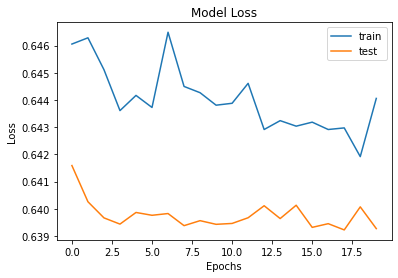

In [38]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

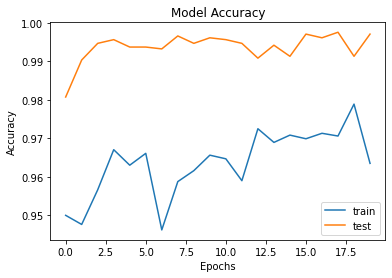

In [39]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [40]:
#calculate loss and accuracy on test data

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_accuracy*100))

65/65 [==============================] - 8s 120ms/step - loss: 0.6393 - accuracy: 0.9971
Test accuracy: 99.71%


[]

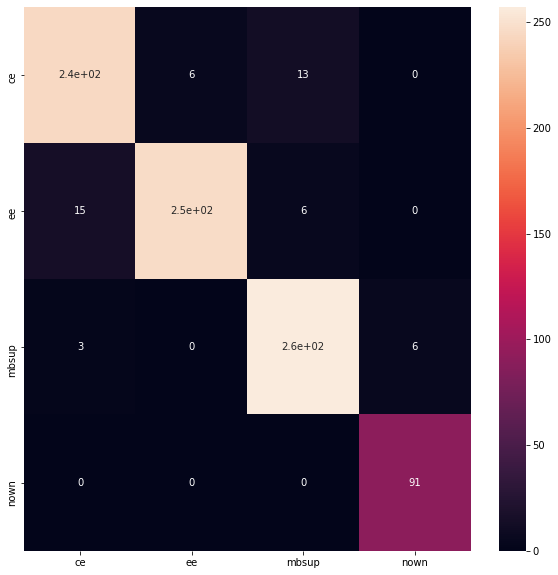

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cat = [c[3:] for c in lb.classes_]
plt.figure(figsize=(10,10))
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
sn.heatmap(cm, annot=True,xticklabels=cat, yticklabels=cat)
plt.plot()

<h2> Making predictions </h2> 

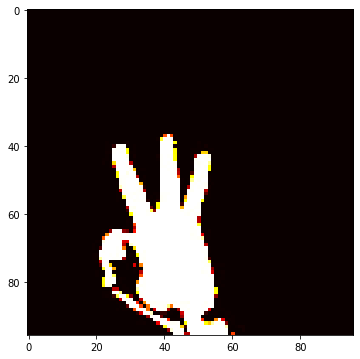

In [58]:
# loading the image 
imgPath = "dataset/three/img817.jpg" 

# Reading the pic 
img = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)


img = cv2.resize(img, (96, 96)); 
img = img_to_array(img) 

plt.figure(figsize=(20, 6))
plt.grid(False) 
plt.imshow(img, cmap="hot") 
plt.show() 

In [51]:
# Expanding the image dimensions 
img = np.expand_dims(img, axis = 0);

# Getting the right predictions 
pred = model.predict(img) 

In [53]:
# Converting into results 
results = np.argmax(pred) 
results = lb.classes_[results]

print("The predicated class is:", results)

The predicated class is: three
